In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#data = pd.read_csv('covid_19.csv')

In [3]:
data.head()

,unique_id,record_id,redcap_repeat_instrument,redcap_repeat_instance,redcap_survey_identifier,covid19_timestamp,sub_id,todays_date,sleepdiary_bedtime,sleepdiary_fallasleep,...,sleepattempt,TST_12,TST,SE,PANAS_PA,PANAS_NA,worry_scale,PHQ9,exercise,fever_temp_C
0,218L,218,covid19,1,NaN,3/23/2020 20:18,1,3/23/2020 16:11,22:30,23:00,...,5.50,0,5.133333,0.843836,14.0,10.0,22.0,5.0,1,NaN
1,341L,341,covid19,1,NaN,3/24/2020 14:43,1,3/24/2020 10:38,23:00,23:15,...,7.75,0,7.533333,0.941667,13.0,10.0,17.0,8.0,1,NaN
2,612L,612,covid19,1,NaN,3/25/2020 21:38,1,3/25/2020 17:33,22:30,22:30,...,6.00,0,5.600000,0.933333,10.0,10.0,25.0,7.0,1,NaN
3,855L,855,covid19,1,NaN,3/27/2020 0:23,1,3/26/2020 20:18,22:30,23:00,...,7.75,0,7.200000,0.847059,13.0,12.0,15.0,6.0,1,NaN
4,954L,954,covid19,1,NaN,3/27/2020 13:20,1,3/27/2020 9:16,23:30,23:30,...,6.25,0,6.083333,0.960526,13.0,10.0,22.0,7.0,1,NaN


## Sleep related features

#### We check the correlation of all the sleep related features to see which of them has the highest effect on the SE. So we choose the sleep related features first.

In [4]:
# segment out sleep related features
sleep_features = ['sleepdiary_bedtime','sleepdiary_fallasleep', 'sleepdiary_sleeplatency', 'sleepdiary_wakes',
       'night_awakening_time', 'sleepdiary_waketime', 'sleepdiary_outofbed',
       'sleepdiary_fellasleep', 'sleepdiary_dreams', 'sleepdiary_nap',
       'sleepdiary_naptime', 'cst', 'sleepdiary_exercise___0', 'sleepdiary_exercise___1',
       'sleepdiary_exercise___2', 'sleepdiary_exercise___3','TIB', 'TIB_12', 'sleepattempt', 'TST_12', 'TST', 'SE', ]
len(sleep_features)

22

In [5]:
df_sleep = data[sleep_features].copy()
df_sleep.shape

(4417, 22)

#### Now we'll go through the correlation heatmap.

In [6]:
corr = df_sleep.corr()
corr.style.background_gradient(cmap='coolwarm')

,sleepdiary_sleeplatency,sleepdiary_wakes,night_awakening_time,sleepdiary_fellasleep,sleepdiary_dreams,sleepdiary_nap,sleepdiary_naptime,cst,sleepdiary_exercise___0,sleepdiary_exercise___1,sleepdiary_exercise___2,sleepdiary_exercise___3,TIB,TIB_12,sleepattempt,TST_12,TST,SE
sleepdiary_sleeplatency,1.000000,0.080453,0.157140,0.664067,0.000216,-0.034860,-0.017202,-0.042423,-0.036600,-0.033584,0.034861,0.028875,0.028347,0.008432,-0.015613,0.012973,-0.277931,-0.442098
sleepdiary_wakes,0.080453,1.000000,0.418845,0.148948,-0.146250,-0.043846,-0.038914,0.081173,-0.092066,0.117346,0.030430,-0.039761,0.108273,0.002280,0.080121,0.004749,-0.078953,-0.258445
night_awakening_time,0.157140,0.418845,1.000000,0.119070,-0.061123,-0.004409,-0.015831,0.100054,-0.032851,0.048513,0.026075,-0.044265,0.152267,0.002108,0.155011,0.010551,-0.167867,-0.437320
sleepdiary_fellasleep,0.664067,0.148948,0.119070,1.000000,-0.011601,-0.044224,-0.016309,-0.040821,nan,nan,nan,nan,-0.023568,0.051787,-0.106665,0.047640,-0.281518,-0.393007
sleepdiary_dreams,0.000216,-0.146250,-0.061123,-0.011601,1.000000,0.067812,0.033784,-0.074298,-0.017341,0.025601,0.001945,-0.019232,-0.121710,-0.014100,-0.104217,-0.022272,-0.078358,0.043906
sleepdiary_nap,-0.034860,-0.043846,-0.004409,-0.044224,0.067812,1.000000,0.748866,-0.040139,0.029712,-0.071437,0.026307,-0.025094,-0.006833,0.085650,0.022465,0.103910,0.042793,0.058525
sleepdiary_naptime,-0.017202,-0.038914,-0.015831,-0.016309,0.033784,0.748866,1.000000,-0.035022,0.053070,-0.063094,0.001762,-0.029348,0.027463,0.047605,0.024271,0.055912,0.036248,0.010821
cst,-0.042423,0.081173,0.100054,-0.040821,-0.074298,-0.040139,-0.035022,1.000000,-0.008262,0.043844,-0.024836,0.062568,-0.043176,0.000305,0.008747,-0.014916,-0.017185,0.041892
sleepdiary_exercise___0,-0.036600,-0.092066,-0.032851,nan,-0.017341,0.029712,0.053070,-0.008262,1.000000,-0.498030,-0.588414,-0.280753,-0.050040,-0.078465,-0.054029,-0.084568,-0.030965,0.033246
sleepdiary_exercise___1,-0.033584,0.117346,0.048513,nan,0.025601,-0.071437,-0.063094,0.043844,-0.498030,1.000000,-0.162570,-0.057159,0.081241,0.057725,0.068624,0.052151,0.049977,-0.045964


In [7]:
df_sleep.isnull().sum()

sleepdiary_bedtime            1
sleepdiary_fallasleep         3
sleepdiary_sleeplatency      21
sleepdiary_wakes              3
night_awakening_time         16
sleepdiary_waketime           9
sleepdiary_outofbed           8
sleepdiary_fellasleep      2434
sleepdiary_dreams             6
sleepdiary_nap               10
sleepdiary_naptime           11
cst                          11
sleepdiary_exercise___0    1983
sleepdiary_exercise___1    1983
sleepdiary_exercise___2    1983
sleepdiary_exercise___3    1983
TIB                          61
TIB_12                        0
sleepattempt                 44
TST_12                        0
TST                          82
SE                          108
dtype: int64

In [8]:
SE_corr = df_sleep.corr()['SE']
correlated = SE_corr.loc[abs(SE_corr) > .1]
correlated.sort_values()

sleepdiary_sleeplatency   -0.442098
night_awakening_time      -0.437320
sleepdiary_fellasleep     -0.393007
sleepdiary_wakes          -0.258445
TIB                       -0.236001
sleepattempt               0.251184
TST                        0.486360
SE                         1.000000
Name: SE, dtype: float64

###### These are the most correlated features with the Sleep Efficiency, but according to the description of the features some are dependant on others. So, it is possible that there is a leakage behind the correlation. Thus, we need to find the root cause of the correlation between these variabe.
##### According to the feature descriptions, SE is calculated by dividing TST by TIB which means it is directly affected by them (Positively by TST and negatively by TIB).<br>
##### TIB is also affected by sleepdiary_outofbed and sleepdiary_bedtime. In other words it is dependant variable.<br>
##### TST is directly dependant on night_awakening_time and sleepdiary_sleeplatency.<br>
##### This concludes that features:<br>
* sleepdiary_bedtime
* sleepdiary_outofbed
* night_awakening_time
* sleepdiary_sleeplatency

#####  are the independant features that effect SE and cause the sleep quality.

In [9]:
df_sleep = data[['night_awakening_time', 'sleepdiary_outofbed', 'sleepdiary_bedtime', 'sleepdiary_sleeplatency', 'SE']].copy()
df_sleep.isnull().sum()

night_awakening_time        16
sleepdiary_outofbed          8
sleepdiary_bedtime           1
sleepdiary_sleeplatency     21
SE                         108
dtype: int64

In [10]:
df_sleep.dropna(axis=0, inplace=True)

In [11]:
X = df_sleep[['night_awakening_time','sleepdiary_outofbed', 'sleepdiary_bedtime', 'sleepdiary_sleeplatency']]
y = df_sleep.SE
y = np.where(y > .8, 1, 0)
print('X: ', X.shape)
print('y: ', y.shape)

X:  (4309, 4)
y:  (4309,)


In [12]:
# Convert all timestamps to integer values
def time_to_int(time):
    import re
    hour = re.search('(.+):', time).group(1)
    minute = re.search(':(.+)', time).group(1)
    return int(hour) + (int(minute)/60)

In [1]:
X['sleepdiary_bedtime'] = X['sleepdiary_bedtime'].apply(time_to_int)
X['sleepdiary_outofbed'] = X['sleepdiary_outofbed'].apply(time_to_int)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (3447, 4)
y_train:  (3447,)
X_test:  (862, 4)
y_test:  (862,)


In [15]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.62      0.50      0.55       224
           1       0.83      0.89      0.86       638

    accuracy                           0.79       862
   macro avg       0.73      0.69      0.71       862
weighted avg       0.78      0.79      0.78       862



# Regression & Classification

In [17]:
data.shape

(4417, 98)

In [18]:
data.isnull().sum()

unique_id                      0
record_id                      0
redcap_repeat_instrument       0
redcap_repeat_instance         0
redcap_survey_identifier    4417
                            ... 
PANAS_NA                    2434
worry_scale                 2434
PHQ9                        2434
exercise                       0
fever_temp_C                4406
Length: 98, dtype: int64

In [19]:
feature=['sleepdiary_sleeplatency', 'sleepdiary_wakes', 'night_awakening_time', 'sleepdiary_fellasleep', 'sleepdiary_dreams', 
         'sleepdiary_nap', 'cst', 'leave_house', 'people_contact', 'socialize', 'alcohol_bev',
         'quarantine', 'fever', 'respiratory', 'tested', 'covid_status', 'TIB', 'sleepattempt', 'TST', 'SE', 'exercise']

In [20]:
df = data[feature].copy()

In [21]:
df.shape

(4417, 21)

In [22]:
df.isnull().sum()

sleepdiary_sleeplatency      21
sleepdiary_wakes              3
night_awakening_time         16
sleepdiary_fellasleep      2434
sleepdiary_dreams             6
sleepdiary_nap               10
cst                          11
leave_house                   7
people_contact               29
socialize                     4
alcohol_bev                  34
quarantine                    7
fever                        10
respiratory                   7
tested                        5
covid_status                 22
TIB                          61
sleepattempt                 44
TST                          82
SE                          108
exercise                      0
dtype: int64

In [23]:
(df.sleepdiary_fellasleep.isnull().sum() / df.shape[0]) * 100

55.10527507357935

In [24]:
df.corr()['sleepdiary_fellasleep'].covid_status

-0.005091372681635394

55% of the column is null and there is no significant correlation between this feature and the label. So we should drop it.

In [25]:
df.drop(columns='sleepdiary_fellasleep', inplace=True)

In [26]:
df.shape

(4417, 20)

In [27]:
df.dropna(axis=0, inplace=True)

In [28]:
df.shape

(4192, 20)

# Regression

## Random Forest Regressor

In [29]:
y = df.SE
X = df.drop(columns='SE')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0, shuffle=True)

In [31]:
RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)

RandomForestRegressor()

In [32]:
y_pred = RFR.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.005464102692085786

### learning curve 

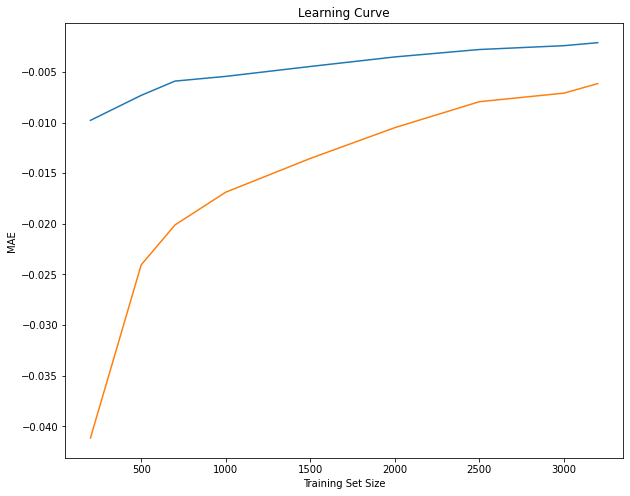

In [33]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=RFR,
    X=X,
    y=y,
    cv=5,
    scoring="neg_mean_absolute_error",
    train_sizes = [200, 500, 700, 1000, 1500, 2000, 2500, 3000, 3200]
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("MAE")

plt.show()

The learning curve indicates that the model is doing well and there is no overfitting or underfitting problem

[Text(0.5, 0, 'Score'), Text(0, 0.5, 'Feature')]

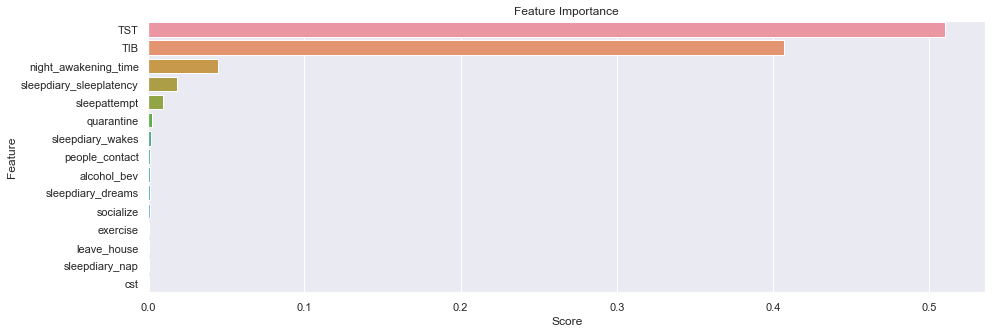

In [34]:
importance_RFR = pd.DataFrame({
    'feature': X_train.columns,
    'score': RFR.feature_importances_
}).sort_values('score', ascending=False)

plt.figure(figsize = (15,5))
sns.set(font_scale = 1)
plt.title('Feature Importance')
ax = sns.barplot(data=importance_RFR.head(15), x='score', y='feature')
ax.set(xlabel='Score', ylabel='Feature')

# The First Classification

## Random Forest Classifier

In [35]:
df_new = df.copy()

In [36]:
df_new['SE'] = np.where(df_new['SE'] >=  0.8,1, 0)

In [37]:
y = df_new.SE
X = df_new.drop(columns='SE')

In [38]:
y.value_counts()

1    3106
0    1086
Name: SE, dtype: int64

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0, shuffle=True)

In [40]:
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)

RandomForestClassifier()

In [41]:
param_grid = {
    'n_estimators': [200,300,400],
    'max_depth':[3,4,5,6]
}

GS = GridSearchCV(estimator=RFC, param_grid=param_grid
      , scoring = 'accuracy', cv=5)


GS.fit(X, y)
GS.best_estimator_

RFC = GS.best_estimator_

In [42]:
y_pred = RFC.predict(X_test)

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.65      0.78       219
           1       0.89      1.00      0.94       620

    accuracy                           0.91       839
   macro avg       0.93      0.82      0.86       839
weighted avg       0.91      0.91      0.90       839



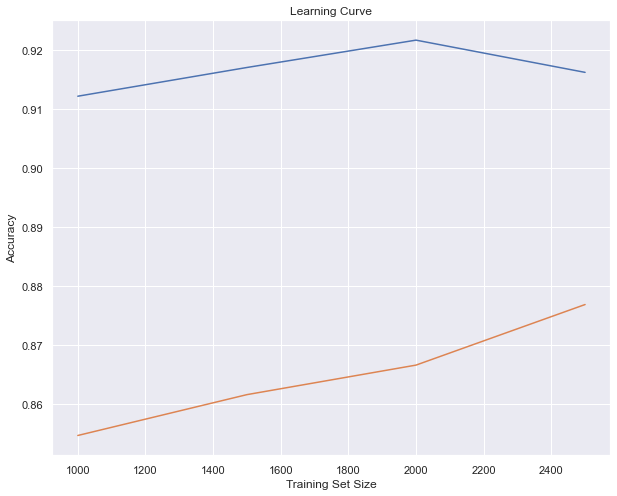

In [45]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=RFC,
    X=X,
    y=y,
    cv=5,
    scoring='accuracy',
    train_sizes = [1000, 1500, 2000, 2500] 
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")

plt.show()

The model is doing well

[Text(0.5, 0, 'Score'), Text(0, 0.5, 'Feature')]

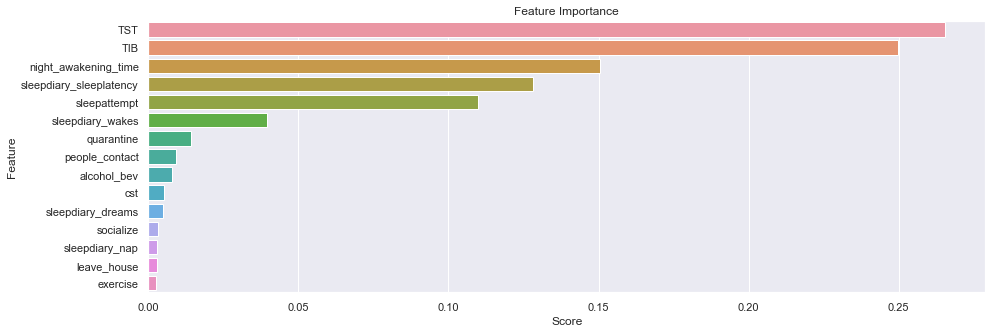

In [44]:
importance_RFC = pd.DataFrame({
    'feature': X_train.columns,
    'score': RFC.feature_importances_
}).sort_values('score', ascending=False)

plt.figure(figsize = (15,5))
sns.set(font_scale = 1)
plt.title('Feature Importance')
ax = sns.barplot(data=importance_RFC.head(15), x='score', y='feature')
ax.set(xlabel='Score', ylabel='Feature')

# The Second Classification

## Random Forest Classifier

In [46]:
y = df.covid_status
X = df.drop(columns='covid_status')

In [47]:
y.value_counts()

0.0    4163
1.0      29
Name: covid_status, dtype: int64

In [48]:
(y.value_counts()[1] / y.value_counts()[0]) * 100

0.6966130194571223

Less than 1% of the data has a value of 1 in the covid_status column! It means the number of Covid patients is too low in the sample. So the dataset is highly imbalanced

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0, shuffle=True)

In [50]:
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)

RandomForestClassifier()

In [51]:
param_grid = {
    'n_estimators': [200,300,400],
    'max_depth':[3,4,5,6]
}

GS = GridSearchCV(estimator=RFC, param_grid=param_grid
      , scoring = 'recall', cv=5)


GS.fit(X, y)
GS.best_estimator_

RFC = GS.best_estimator_

In [52]:
y_pred = RFC.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       832
         1.0       1.00      0.57      0.73         7

    accuracy                           1.00       839
   macro avg       1.00      0.79      0.86       839
weighted avg       1.00      1.00      1.00       839



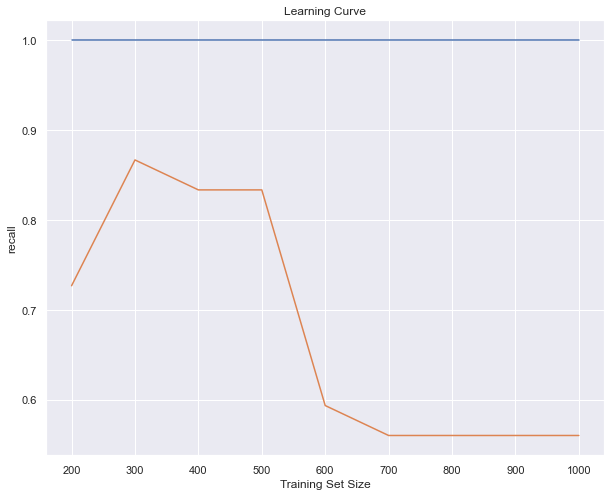

In [53]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=RFC,
    X=X,
    y=y,
    cv=5,
    scoring='recall',
    train_sizes = [200, 300, 400, 500, 600, 700, 1000]

)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("recall")

plt.show();

The training is overfitted because of the highly imbalanced dataset.

[Text(0.5, 0, 'Score'), Text(0, 0.5, 'Feature')]

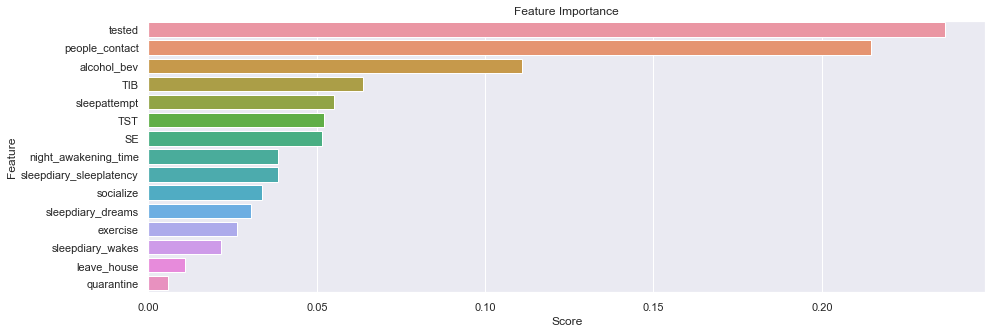

In [54]:
importance_RFC = pd.DataFrame({
    'feature': X_train.columns,
    'score': RFC.feature_importances_
}).sort_values('score', ascending=False)

plt.figure(figsize = (15,5))
sns.set(font_scale = 1)
plt.title('Feature Importance')
ax = sns.barplot(data=importance_RFC.head(15), x='score', y='feature')
ax.set(xlabel='Score', ylabel='Feature')

## Logistic Regression

In [55]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0, shuffle=True)

In [57]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

LogisticRegression()

In [58]:
param_grid = {
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

GS = GridSearchCV(estimator=LR, param_grid=param_grid
      , scoring = 'recall', cv=5)


GS.fit(X, y)
GS.best_estimator_

RFC = GS.best_estimator_
RFC

LogisticRegression(solver='liblinear')

In [59]:
y_pred = LR.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       832
         1.0       1.00      0.14      0.25         7

    accuracy                           0.99       839
   macro avg       1.00      0.57      0.62       839
weighted avg       0.99      0.99      0.99       839



### Learning Curve

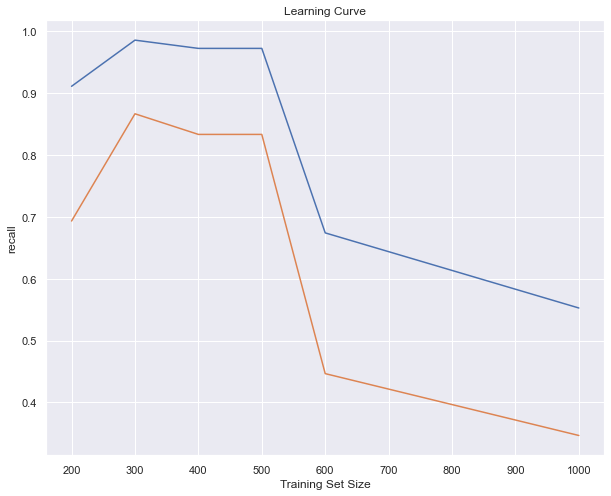

In [60]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=LR,
    X=X,
    y=y,
    cv=5,
    scoring='recall',
    train_sizes = [200, 300, 400, 500, 600, 1000] 
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("recall")

plt.show()

Both the RandomForest and LigisticRegression indicate that because of the special conditions of the covid_status column(less than 1% of the inctances are Covid patients), we can not train the model with more than 500 instances. training More than this number will lead overfitting or underfitting.

# Does covid affect the SE?

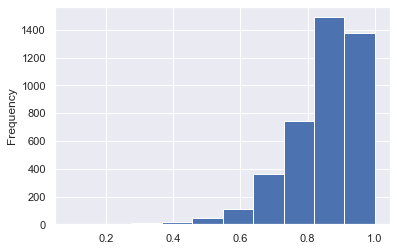

In [61]:
df[df['covid_status']==0].SE.plot.hist();

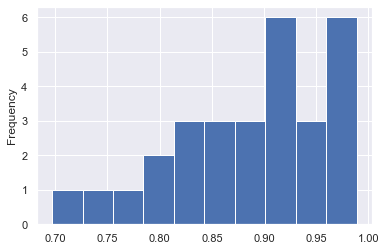

In [62]:
df[df['covid_status']==1].SE.plot.hist();

In [63]:
df.groupby('covid_status').SE.mean()

covid_status
0.0    0.847232
1.0    0.887670
Name: SE, dtype: float64

In [64]:
df.groupby('covid_status').SE.median()

covid_status
0.0    0.870370
1.0    0.904762
Name: SE, dtype: float64

There is a little difference between the means of SE for Covid and NoCovid groups. Is this difference significant or not? To answer this question we used a treshold of 0.8 for SE(we did this in the previous parts). We also applied statistical T_Tes. 

In [65]:
cat1 = df_new[df_new['covid_status']==0]
cat2 = df_new[df_new['covid_status']==1]

ttest_ind(cat1['SE'], cat2['SE'])

Ttest_indResult(statistic=-1.9197970220070755, pvalue=0.054951369334948943)

The T_Test rejects the difference. The pvalue is more than 0.05. It means There isn't a significant difference between the means of two groups. Covid people had the same Sleep Efficiency value as the others.

This confirms the results of imprtant features in the first classification. The covid_status was not an important feature.